## Name: Utsav Basu
## Roll No.: 20CS30057
## Programming Assignment 1: GP Regression

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple, Callable, List

%matplotlib inline

seed = 42
np.random.seed(seed)


### Read and Preprocess Data

Data is read from the file and stored in a pandas DataFrame. The data is then normalized by subtracting the mean and dividing by the standard deviation.

In [2]:
raw_dataframe = pd.read_excel("energy+efficiency/ENB2012_data.xlsx")
print(raw_dataframe.head())

print('Mean of the raw_dataframe:')
print(raw_dataframe.mean())
print('Standard deviation of the raw_dataframe:')
print(raw_dataframe.std())

# Normalizing the data
dataframe = (raw_dataframe - raw_dataframe.mean()) / raw_dataframe.std()
print(dataframe.head())

X = dataframe.iloc[:, :-2]
Y = dataframe.iloc[:, -2:]

print(X.head())
print(Y.head())

     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
Mean of the raw_dataframe:
X1      0.764167
X2    671.708333
X3    318.500000
X4    176.604167
X5      5.250000
X6      3.500000
X7      0.234375
X8      2.812500
Y1     22.307195
Y2     24.587760
dtype: float64
Standard deviation of the raw_dataframe:
X1     0.105777
X2    88.086116
X3    43.626481
X4    45.165950
X5     1.751140
X6     1.118763
X7     0.133221
X8     1.550960
Y1    10.090204
Y2     9.513306
dtype: float64
         X1        X2        X3        X4        X5        X6      X7  \
0  2.040447 -1.784712 -0.561586 -1.469119  0.999349 -1.340767 -1.7593   
1  2.040447 -1.784712 -0.561586 -1.469119  0.999349 -0

### Data Visualization

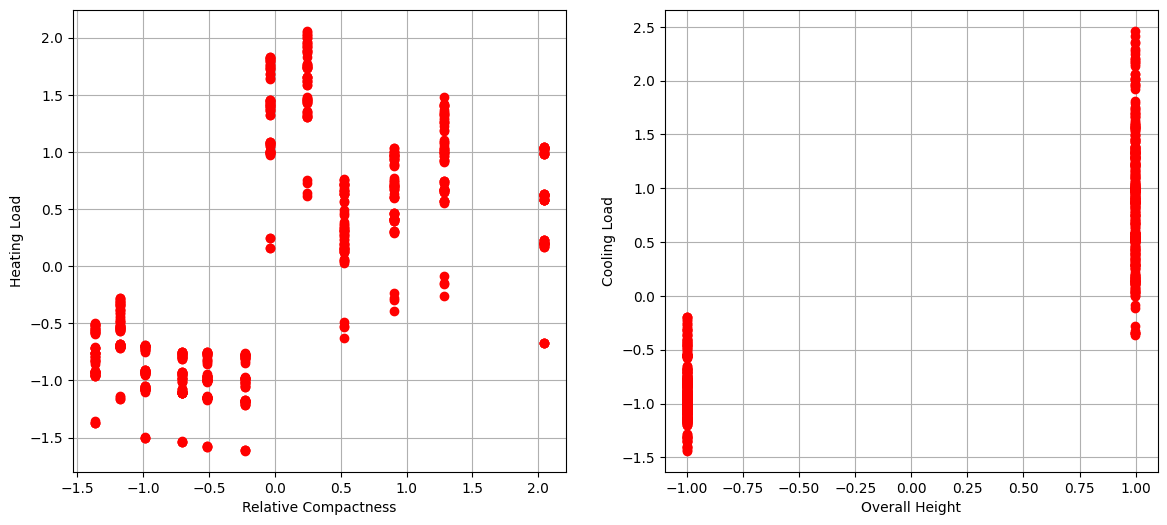

In [3]:
plt.figure(figsize=(14, 6), dpi=100)

plt.subplot(1, 2, 1)
plt.plot(dataframe['X1'], dataframe['Y1'], 'ro')
plt.grid()
plt.xlabel('Relative Compactness')
plt.ylabel('Heating Load')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(dataframe['X5'], dataframe['Y2'], 'ro')
plt.grid()
plt.xlabel('Overall Height')
plt.ylabel('Cooling Load')
plt.show()

### Kernel Function

We are using the sqaured exponential kernel for this assignment [also known as the Radial Basis Function (RBF) kernel].

The kernel is defined as follows:

$$
k(x, x') = \sigma_f^2 \exp \left( -\frac{(x - x')^2}{2l^2} \right)
$$

where $\sigma_f^2$ is the variance and $l$ is the length scale (bandwidth).

In [4]:
def rbf_kernel(
    sigma: float,
    bandwidth: float,
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    """ 
    Here we define the kernel function. We use the squared exponential kernel.
    The kernel function is used to calculate the covariance matrix.

    Args:
        sigma (float) : The standard deviation of the Gaussian distribution.
        bandwidth (float) : The bandwidth of the Gaussian distribution.
        x (np.ndarray) : The first point at which the kernel function is to be evaluated.
        y (np.ndarray) : The second point at which the kernel function is to be evaluated.

    Returns:
        float: The value of the kernel function at points x and y.
    """

    return np.exp(-1 * np.linalg.norm(x - y) ** 2 / (2 * bandwidth ** 2)) * sigma ** 2

# END def kernel

In [5]:
def kernel_matrix(
    kernel: Callable,
    X: np.ndarray,
    Y: np.ndarray,
) -> np.ndarray:
    """ 
    Helper function to calculate the kernel matrix.
    The kernel matrix is used to calculate the covariance matrix.

    Args:
        sigma (float) : The standard deviation of the Gaussian distribution.
        bandwidth (float) : The bandwidth of the Gaussian distribution.
        X (np.ndarray) : The data matrix
        Y (np.ndarray) : The data matrix

    Returns:
        np.ndarray: The kernel matrix.
    """

    N1 = X.shape[0]
    N2 = Y.shape[0]

    K = np.zeros((N1, N2))

    for i in range(N1):
        for j in range(N2):
            K[i, j] = kernel(X[i], Y[j])
        # END for j
    # END for i

    return K

# END def kernel_matrix

### Gaussian Process Regression Class

We want to learn a function $$f(x)$$ such that $$y = f(x) + \epsilon$$ where $$\epsilon \sim \mathcal{N}(0, \sigma_n^2)$$ is the noise. The Gaussian Process Regression model is defined as follows:

$$
\begin{bmatrix}
y \\
y_*
\end{bmatrix}
\sim
\mathcal{N} \left(
\begin{bmatrix}
\mu \\
\mu_*
\end{bmatrix},
\begin{bmatrix}
K & K_* \\
K_*^T & K_{**}
\end{bmatrix}
\right)
$$

where $$y$$ is the training labels, $$y_*$$ is the test labels, $$\mu$$ is the mean of the training labels, $$\mu_*$$ is the mean of the test labels, $$K$$ is the kernel matrix of the training data, $$K_*$$ is the kernel matrix between the training and test data, and $$K_{**}$$ is the kernel matrix of the test data.

The mean of the test labels is given by:

$$
\mu_* = K_*^T K^{-1} y
$$

The variance of the test labels is given by:

$$
\sigma_*^2 = K_{**} - K_*^T K^{-1} K_*
$$


In short, the Gaussian Process Regression class is a wrapper around the kernel functions and the data. It has the following methods:



1. `fit(X, y)`: This method fits the data to the Gaussian Process Regression model. It takes in the training data `X` and the training labels `y` as input. It also computes the kernel matrix `K` and the inverse of the kernel matrix `K_inv` which are used in the prediction step.
2. `predict(X)`: This method predicts the labels for the test data `X`. It takes in the test data `X` as input and returns the predicted labels `y_pred` as output. It also computes the variance of the predictions `y_pred_var` which is used in the confidence interval computation.

In [6]:
class GaussianProcessRegression:
    """ 
    Here we define the GaussianProcessRegression class. 
    The GaussianProcessRegression class is used to fit the Gaussian Process Regression model 
    to the data and predict the output for the test data.
    """

    def __init__(
        self,
        kernel: Callable,
        sigma: List[float],
        bandwidth: List[float],
        err_var: float = 0.1,
    ) -> None:
        """ 
        Here we initialize the GaussianProcessRegression class.

        Args:
            sigma (float) : The standard deviation of the Gaussian distribution.
            bandwidth (float) : The bandwidth of the Gaussian distribution.
            X (np.ndarray) : The training data.
            Y (np.ndarray) : The output for the training data.
        """

        self.kernel = kernel
        self.sigma = sigma
        self.bandwidth = bandwidth
        self.err_var = err_var

    # END def __init__

    def fit(
        self,
        X_train: np.ndarray,
        Y_train: np.ndarray,
    ) -> None:
        """ 
        Here we fit the Gaussian Process Regression model to the data.

        Args:
            X (np.ndarray) : The training data.
            Y (np.ndarray) : The output for the training data.

        """

        self.X_train = X_train
        self.Y_train = Y_train
        self.K = [kernel_matrix(lambda x, y: self.kernel(s, b, x, y), X_train, X_train)
                  for (s, b) in zip(self.sigma, self.bandwidth)]
        self.K = [k + self.err_var * np.eye(k.shape[0]) for k in self.K]
        self.K_inv = [np.linalg.inv(k) for k in self.K]

    # END def fit

    def predict(
        self,
        X_test: np.ndarray,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """ 
        Here we predict the output for the test data.

        Args:
            X (np.ndarray) : The test data.

        Returns:
            np.ndarray: The means of the predicted output for the test data.
            np.ndarray: The variance of the predicted output for the test data.
        """

        y_pred_mean = np.zeros((X_test.shape[0],
                                self.Y_train.shape[1]))

        y_pred_var = np.zeros((X_test.shape[0],
                               self.Y_train.shape[1]))

        for i in range(self.Y_train.shape[1]):
            def kernel(x, y): return self.kernel(self.sigma[i],
                                                 self.bandwidth[i],
                                                 x, y)
            k_star = kernel_matrix(kernel,  self.X_train, X_test)

            y_pred_mean[:, i] = k_star.T @ self.K_inv[i] @ self.Y_train[:, i]

            y_pred_var[:, i] = np.diag(kernel_matrix(kernel, X_test, X_test) -
                                       k_star.T @ self.K_inv[i] @ k_star)
        # END for i

        return y_pred_mean, y_pred_var

    # END def predict

# END class GaussianProcessRegression

### Gaussian Process Regression

Here we use the Gaussian Process Regression class to fit the data and predict the labels for the test data. We also compute the confidence interval for the predictions. 
The data is split into training and testing sets. The training set is used to train the model and the testing set is used to evaluate the model.

#### Train Test Split (80-20)

In [7]:
f_test = 0.2
N = X.shape[0]
N_train = int((1 - f_test) * N)
N_test = N - N_train

# Shuffle the data
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X.iloc[idx]
Y = Y.iloc[idx]

# print(X_new.head())
# print(Y_new.head())

# Split the data into training and testing data
X_train = X.iloc[:N_train]
Y_train = Y.iloc[:N_train]
X_test = X.iloc[N_train:]
Y_test = Y.iloc[N_train:]

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(614, 8) (154, 8)
(614, 2) (154, 2)


#### Predictions and Plots

In [8]:
def mean_squared_error(
    Y_true: np.ndarray,
    Y_pred: np.ndarray,
) -> float:
    """ 
    Here we calculate the mean squared error.

    Args:
        Y_true (np.ndarray) : The true output.
        Y_pred (np.ndarray) : The predicted output.

    Returns:
        float: The mean squared error.
    """
    return float(np.mean(np.square(Y_true - Y_pred)))
# END def mean_squared_error

In [9]:
def plot_results(
    Y_pred: np.ndarray,
    var_Y_pred: np.ndarray,
    Y_test: pd.DataFrame,
):
    """
    Helper function to plot the results.

    Args:
        Y_pred (np.ndarray): Predicted output.
        var_Y_pred (np.ndarray): Variance of the predicted output.
        Y_test (pd.DataFrame): True output.
    """
    
    plt.figure(figsize=(14, 14), dpi=100)

    plt.subplot(2, 2, 1)
    plt.plot(Y_test['Y1'].to_numpy(), Y_pred[:, 0], 'ro')
    line = np.linspace(Y_test['Y1'].min()*1.1, Y_test['Y1'].max()*1.1, 1000)
    plt.plot(line, line, 'b-')
    plt.xlabel('Actual Heating Load')
    plt.ylabel('Predicted Heating Load')
    plt.grid()
    # plt.show()

    plt.subplot(2, 2, 2)
    plt.plot(Y_pred[:, 0], var_Y_pred[:, 0], 'ro')
    plt.xlabel('Predicted Heating Load')
    plt.ylabel('Variance of Predicted Heating Load')
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.grid()
    # plt.show()

    plt.subplot(2, 2, 3)
    plt.plot(Y_test['Y2'].to_numpy(), Y_pred[:, 1], 'ro')
    line = np.linspace(Y_test['Y2'].min()*1.1, Y_test['Y2'].max()*1.1, 1000)
    plt.plot(line, line, 'b-')
    plt.xlabel('Actual Cooling Load')
    plt.ylabel('Predicted Cooling Load')
    plt.grid()
    # plt.show()

    plt.subplot(2, 2, 4)
    plt.plot(Y_pred[:, 1], var_Y_pred[:, 1], 'ro')
    plt.xlabel('Predicted Cooling Load')
    plt.ylabel('Variance of Predicted Cooling Load')
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.grid()

    plt.show()

`sigma` and `bandwidth` are the hyperparameters of rbf kernel used in the Gaussian Process Regression model.

The plots show the predictions vs the actual values for the test data. The variance of the predictions is also plotted.

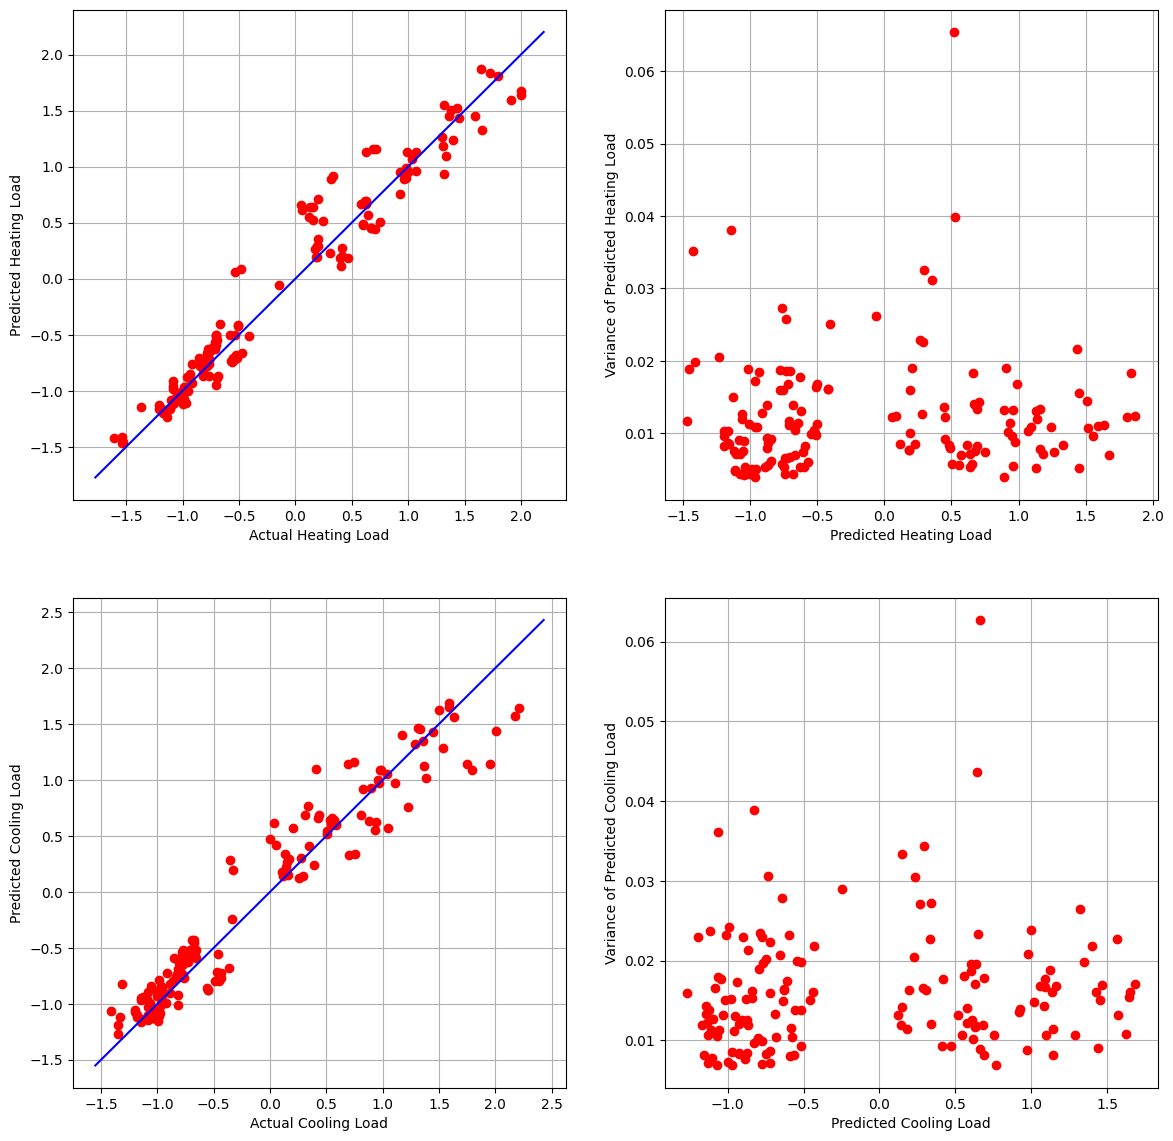

Mean squared error for Y1: 0.04208433945417499
Mean squared error for Y2: 0.06296588714181602


In [10]:
sigma: List[float] = [0.8, 0.4]
bandwidth: List[float] = [2.5, 1.6]
err_var = 0.1

gpr = GaussianProcessRegression(kernel=rbf_kernel,
                                sigma=sigma,
                                bandwidth=bandwidth,
                                err_var=err_var)

gpr.fit(X_train=X_train.to_numpy(),
        Y_train=Y_train.to_numpy())

Y_pred, var_Y_pred = gpr.predict(X_test=X_test.to_numpy())

plot_results(Y_pred=Y_pred,
             var_Y_pred=var_Y_pred,
             Y_test=Y_test)

print('Mean squared error for Y1:',
      mean_squared_error(Y_test['Y1'].to_numpy(),
                         Y_pred[:, 0]))
print('Mean squared error for Y2:',
      mean_squared_error(Y_test['Y2'].to_numpy(),
                         Y_pred[:, 1]))

So from the above plots we can see that the GP Regression model is able to fit and predict the data well. The uncertainty in the predictions is also low.
The model is able to capture the trend of the data and also the uncertainty in the data points. The model is able to predict the test data well and the uncertainty in the predictions is also low. 

#### Cross Validation

In [11]:
def cross_validation(
    kernel: Callable,
    sigma: List[float],
    bandwidth: List[float],
    X: np.ndarray,
    Y: np.ndarray,
    k: int,
) -> Tuple[float, float]:
    """ 
    Here we perform k-fold cross validation.

    Args:
        sigma (float)
        bandwidth (float)
        X (np.ndarray) : The training data.
        Y (np.ndarray) : The output for the training data.
        k (int) : The number of folds.

    Returns:
        float: The mean squared error.
    """
    N = X.shape[0]
    n = N // k
    mse: Tuple[float, float] = (0, 0)

    for i in range(k):
        X_train = np.concatenate((X[: i * n], X[(i + 1) * n:]))
        Y_train = np.concatenate((Y[: i * n], Y[(i + 1) * n:]))
        X_test = X[i * n: (i + 1) * n]
        Y_test = Y[i * n: (i + 1) * n]
        gpr = GaussianProcessRegression(kernel=kernel,
                                        sigma=sigma,
                                        bandwidth=bandwidth)
        gpr.fit(X_train=X_train, Y_train=Y_train)
        Y_pred, _ = gpr.predict(X_test=X_test)
        m1 = mean_squared_error(Y_test[:, 0], Y_pred[:, 0])
        m2 = mean_squared_error(Y_test[:, 1], Y_pred[:, 1])
        mse = (mse[0] + m1, mse[1] + m2)
    # END for
    return mse[0] / k, mse[1] / k
# END def cross_validation

In [12]:
cross_val = cross_validation(kernel=rbf_kernel,
                             sigma=sigma,
                             bandwidth=bandwidth,
                             X=X.to_numpy(),
                             Y=Y.to_numpy(),
                             k=5)

print('Cross Validation Error for Y1:', cross_val[0])
print('Cross Validation Error for Y2:', cross_val[1])

Cross Validation Error for Y1: 0.04784215172734114
Cross Validation Error for Y2: 0.07252184888278759


We also observe that the 5-fold cross validation error is low and the model is able to generalize well.